In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as k
import numpy as np
from scipy.stats import norm
from time import time

In [2]:

def blackScholesPriceTrue(fwd, strike, mat, vol):
    sqt = vol * np.sqrt(mat)
    d1 = (np.log(fwd / strike) + 0.5 * vol* vol * mat)/sqt
    d2 = d1 - sqt
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    return n1 - strike/fwd * n2

def createDataset(size):
    f = np.linspace(0.5,1.5, size)
    strike = np.linspace(0.5,1.5, size)
    T = np.linspace(0.1,1,size)
    vol = np.linspace(0.01, 0.5, size)
    inputs = np.array(np.meshgrid(f,strike,T,vol)).T.reshape(-1, 4)
    options = blackScholesPriceTrue(inputs[:,0],inputs[:,1], inputs[:,2], inputs[:,3])
    return inputs, options

class OptionsSequence(k.utils.Sequence):

    def __init__(self, dataSetSize, batch_size):
        self.x, self.y = createDataset(dataSetSize)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size,:]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_x, batch_y


In [3]:

def add_normalized_layer(h_units, activation='relu'):
    return [
        k.layers.Dense(h_units, use_bias=False),
        k.layers.BatchNormalization(),
        k.layers.Activation(activation)
            ]

def create_model(h_layers, h_units, modelFile = None):
    layers = [k.layers.Dense(units=h_units,  input_dim=4)]
    layers +=[k.layers.Dropout(rate=0.8)]
    for _ in range(h_layers):
        layers += add_normalized_layer(h_units)
    layers += [k.layers.Dense(units=1, activation='elu')]
    model = k.models.Sequential(layers)
    optimizer = k.optimizers.RMSprop(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    if modelFile is not None:
        try:
            model.load_weights(modelFile)
        except:
            pass
    return model


In [4]:

generator = OptionsSequence(10,200)
val_generator = OptionsSequence(5, 5**4)


In [5]:
modelFile = 'bsPricerModel.hdf5'
layers = 8
hidden_units = 256
model = create_model(layers, hidden_units, modelFile)

epochs = 0
checkpoint = k.callbacks.ModelCheckpoint(modelFile,monitor='val_loss')
tensorboard = k.callbacks.TensorBoard(log_dir='LOGS\\{}'.format(time()), histogram_freq=1, write_graph=True)
model.fit_generator(generator=generator, epochs=epochs, validation_data=val_generator, validation_freq=2, 
                    workers=4, verbose=1, callbacks=[checkpoint, tensorboard])


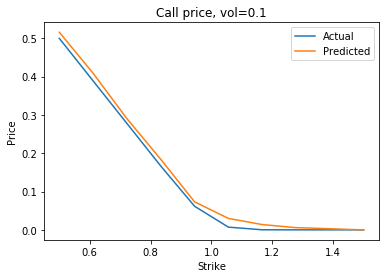

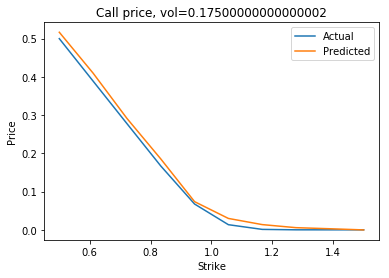

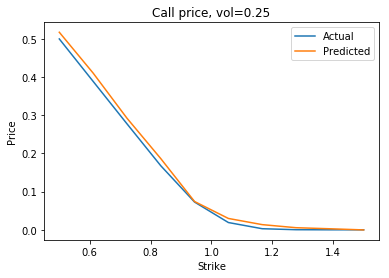

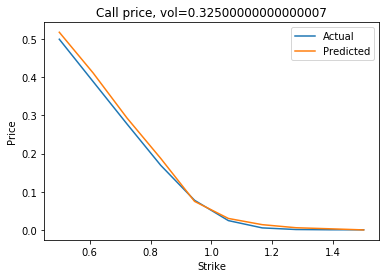

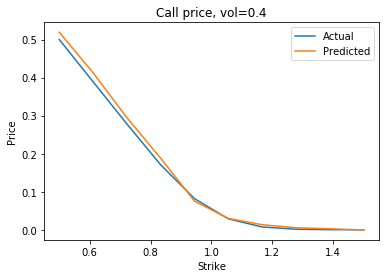

In [10]:
vols = np.linspace(0.1,0.4, 5)
for i in range(5):
    f, strike, t, vol = [1], np.linspace(0.5, 1.5, 10), vols[i], [0.2]
    model = create_model(layers, hidden_units, modelFile)
    inputs = np.array(np.meshgrid(f, strike, t, vol)).T.reshape(-1, 4)
    prices = blackScholesPriceTrue(inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3])
    pred_prices = model.predict(inputs)
    plt.figure(i)
    plt.title("Call price, vol={}".format(vols[i]))
    plt.plot(strike, prices, label='Actual')
    plt.plot(strike, pred_prices, label='Predicted')
    plt.xlabel("Strike")
    plt.ylabel("Price")
    plt.legend()